In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Computer vision
## Session 5a
### Eigen Faces - an application of Principal Component Analysis (PCA) for human faces



In [1]:
# Import some libraries
import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import cv2

%matplotlib inline

# %matplotlib notebook

In [2]:
# Some basic parameters
inpDir = '../input'
outDir = '../output'
dataDir = 'CelebAMask-HQ/CelebA-HQ-img'

RANDOM_STATE = 24

np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (9, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'medium',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = 'jet'

LINE_THICK = 1

# Arbit color to mark rectangles on the images
MARK_COLOR = (15, 82, 186)

# Number of EigenFaces.
NUM_EIGEN_FACES = 10

# Maximum weight.
MAX_SLIDER_VALUE = 255


# Max Images to load from source Dir
MAX_IMAGE = 50

## PCA - a dimensionality reduction technique



<img src='images/S05a_fig1.png' width='400' alt="S05a_fig1.png"/>



The first principal component is the direction of maximum variance in the data. The second principal component is the direction of maximum variance in the space perpendicular (orthogonal) to the first principal component and so on and so forth. The first and second principal components the 2D data are shown above.

We also learned that the first principal component is the $eigenvector$ of the covariance matrix corresponding to the maximum $eigenvalue$. 

The second principal component is the $eigenvector$ corresponding to the second largest $eigenvalue$.

This algorithm considers the fact that not all parts of a face are equally important and equally useful. When you look at some one you recognize him/her by his distinct features like eyes, nose, cheeks, forehead and how they vary with respect to each other. So you are actually focusing on the areas of maximum change (mathematically speaking, this change is variance) of the face. For example, from eyes to nose there is a significant change and same is the case from nose to mouth. When you look at multiple faces you compare them by looking at these parts of the faces because these parts are the most useful and important components of a face. Important because they catch the maximum change among faces, change that helps you differentiate one face from the other. This is exactly how EigenFaces face recognizer works.  

EigenFaces face recognizer looks at all the training images of all the persons as a whole and try to extract the components which are important and useful (the components that catch the maximum variance/change) and discards the rest of the components. This way it not only extracts the important components from the training data but also saves memory by discarding the less important components. These important components it extracts are called **principal components**. 

Below is an image showing the principal components extracted from a list of faces.

<img src = 'images/eigenfaces_opencv.png'/>


**Eigenfaces algorithm also considers illumination as an important component**.

### Eigen Faces

Eigenfaces are images that can be added to a mean (average) face to create new facial images. We can write this mathematically as,

$F = F_m + \sum^n_{i=1} \alpha_i F_i$

where,

- F is a new face
- $F_m$ is the mean or the average face
- $F_i$ is an EigenFace
- $\alpha_i$ are scalar multipliers to create new faces. This is one parameter we need tpo tune and they can be positive or negative.

#### Steps to calculate EigenFaces
We will be using a facial image dataset : about 200 images from CelebA.

- **Align and resize images**: align and resize images so the center of the eyes are aligned in all images.
- **Create a data matrix**: Create a data matrix containing all images as a row vector. If all the images in the dataset are of size 100 x 100 and there are 1000 images, we will have a data matrix of size 30k x 1000.
- **Calculate Mean Vector**: Before performing PCA on the data, we need to subtract the mean vector. This is not necessary for using OpenCV’s PCA class is because OpenCV calculates the mean if the vector is not supplied.
- **Calculate Principal Components**: supply the data matrix, to get matrix containing the Eigenvectors
- **Reshape Eigenvectors to obtain EigenFaces**: The Eigenvectors so obtained will be one dimentional, we can reshape these Eigenvectors into shape of images to obtain EigenFaces.

## Helper function

In [3]:
# Function to plot one image

def fn_plot_one_img(im, cmap = CMAP):
    
    '''
    Args:
        im : image to display and save
    
    '''
    # showing image
    plt.imshow(im, cmap = cmap)
    plt.axis('off')
    plt.show()

    
# Function to plot multiple images

def fn_plot_images(im_lst):
    '''
    Args:
        img_list: list of images
    '''
    nRows = 1
    nCols = len(im_lst)
    
    
    fig, axes = plt.subplots(nRows, nCols)
    
    for i in range(nCols):
        axes[i].imshow(im_lst[i]['img'], cmap = im_lst[i]['cmap'])
        axes[i].set_title(im_lst[i]['name'])

        axes[i].set_xticklabels([]);
        axes[i].set_yticklabels([]);
                
    plt.tight_layout()
    
    plt.show()

### Read Images

In [4]:
# # Function to read images from the directory.
def fn_read_images_from_dir(path):
    
    print("Reading images from " + path, end = "...")
    
    # Create array of array of images.
    images = []
    
    # How many images to load
    iCount =0
    
    # List all files in the directory and read points from text files one by one.
    for filePath in sorted(os.listdir(path)):
            
        # Split the path to get file extn
        fileExt = os.path.splitext(filePath)[1]
        # consider jpg imges only
        if fileExt in [".jpg", ".jpeg"]:

            # Add to array of images.
            imPath = os.path.join(path, filePath)
            
            # read images at the imgPath
            im = cv2.imread(imPath)

            if im is None :
                
                # Did not find an Images? say so...
                print("image:{} not read properly".format(imagePath))
                
            else :
                
                # Convert image to floating point.
                im = np.float32(im)/255.0
                
                # Add image to list.
                images.append(im)
                
                # Flip image about vertical axis.
                # Assuming that its face up image
                imFlip = cv2.flip(im, 1); 
                
                # Append flipped image.
                images.append(imFlip)
                
                iCount+= 1
                
                if iCount> MAX_IMAGE:
                    break
    
    numImages = int(len(images) / 2)
    
    # Exit if no image found.
    
    if numImages == 0 :
        print("No images found")
        sys.exit(0)

    print(str(numImages) + " files read.")
    
    return images


# Read an Image 
def fn_read_image(fileName):
    '''
    Args:
        fileName : Path of image file to read
    returns:
        im: image in cv2 format
        rgbIm: image in RGB format
    
    '''
    imgPath = os.path.join(inpDir, dataDir, fileName)
    
    # Read image file
    im = cv2.imread(imgPath, cv2.IMREAD_COLOR)
    
    
    if im is None:
        print('Could not open or find the image:', fileName)
        exit(0)
    else:
        # convert to RGB image
        rgbIm = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
        return im, rgbIm

###  Create Data Matrix

Create a data matrix containing all images as a row vector. Next, we use the function createDataMatrix to assemble the images into a data matrix. Each row of the data matrix is one image. Let’s look into the createDataMatrix function. If all the images in the dataset are of size 100 x 100 and there are 1000 images, we will have a data matrix of size 30k x 1000. So, according to our example, numImages = 1000, sz[0] = 100, sz[1] = 100 and sz[2] = 3. flatten returns a copy of the array collapsed into one dimension

In [5]:
# Create data matrix from a list of images.
def fn_create_data_matrix(imgs):
    '''
    Args:
        imgs: list of images to flatten
    Return: 
        List of flattened images
    '''
    
    # Tell me if you have started working!
    print("Creating data matrix", end = " ... ")

    # How many images
    numImages = len(images)
    
    # Get size of the image (height, width, channels)
    sz = images[0].shape
    
    # Convert to Flattened images.
    data = np.zeros((numImages, sz[0] * sz[1] * sz[2]), dtype = np.float32)
    
    for i in range(0, numImages):
        
        
        image = images[i].flatten()
        
        # Each row get replaced with one flattened image.
        data[i,:] = image
        
    
    # Still working? 
    print("Done")
    
    return data

Reading images from ../input/CelebAMask-HQ/CelebA-HQ-img...51 files read.


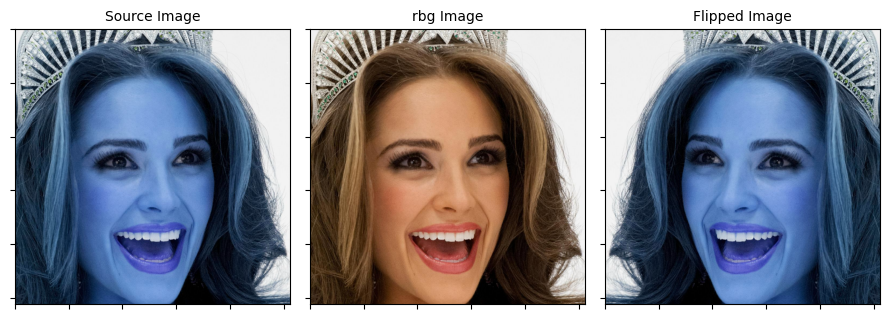

In [6]:
imgDirName = os.path.join(inpDir, dataDir)

images = fn_read_images_from_dir(imgDirName)

srcImg = images[0]

rbgImg =  cv2.cvtColor(srcImg,cv2.COLOR_BGR2RGB)

flipImg = cv2.flip(srcImg, 3);

img_lst = [{'img': srcImg, 'name': 'Source Image','cmap' : CMAP},
           {'img': rbgImg, 'name': 'rbg Image','cmap' : CMAP},
           {'img': flipImg, 'name': 'Flipped Image','cmap' : CMAP}]

fn_plot_images(img_lst)

In [7]:
images = []

images.append(srcImg)

images.append(flipImg)

dm = fn_create_data_matrix(images)
dm[0].shape

Creating data matrix ... Done


(3145728,)

### Generate New Face

The averageFace is calculated below in the main function. We add the output and the weighted eigen faces to generate different results. The weight parameter is acquired from the trackbar position. We use the logic, weight = sliderValues[i] - MAX_SLIDER_VALUE/2 as OpenCV does not allow slider values to be negative. Finally we resize the image to double of its original size.

In [8]:
def fn_create_new_face(*args):
    #print ('len of Slider Values', len(sliderValues))
    # Start with the mean image.
    output = averageFace

    # Add the eigen faces with the weights.
    for i in range(0, len(sliderValues)):
        
        # Get trackbar position.
        sliderValues[i] = cv2.getTrackbarPos("Weight" + str(i), "Trackbars");
        
        weight = sliderValues[i] - MAX_SLIDER_VALUE/2
        
        # Add the weighted eigen face to the mean face.
        output = np.add(output, eigenFaces[i] * weight)

    # Display Result at 2x size.
    output = cv2.resize(output, (0,0), fx = 2, fy = 2)
    
    cv2.imshow("Result", output)

### Reset Sliders

This is the callback function for mouse hover on the Average named window. By doing so, we reset the sliders and at the same time reset the output to its preveous state.

In [9]:
def fn_reset_slider_values(*args):
    
    for i in range(0, NUM_EIGEN_FACES):
        
        cv2.setTrackbarPos(f'Weight {str(i)}', 'Trackbars', int(MAX_SLIDER_VALUE/2))
        
    fn_create_new_face()

In [ ]:
imgDirName = os.path.join(inpDir, dataDir)

images = fn_read_images_from_dir(imgDirName)

# Size of images.
sz = images[0].shape

# Create data matrix for PCA.
data = fn_create_data_matrix(images)

# Compute the eigenvectors from the stack of images created.
print('Calculating PCA ', end = '...')

mean, eigenVectors = cv2.PCACompute(data, mean = None, maxComponents = NUM_EIGEN_FACES)

# Are you done!
print ('Done')

averageFace = mean.reshape(sz)

# Create a container to hold eigen faces.
eigenFaces  = []

# Reshape eigen vectors to eigen faces.
for eigenVector in eigenVectors:

    # Reshape.
    eigenFace = eigenVector.reshape(sz)

    # Append eigen faces to the container.
    eigenFaces.append(eigenFace)

# Create window for displaying result.
cv2.namedWindow("Result", cv2.WINDOW_NORMAL)

# Create window for displaying mean face.
cv2.namedWindow("Average", cv2.WINDOW_NORMAL)

# Upscale by a factor of two.
output = cv2.resize(averageFace, (0,0), fx = 2, fy = 2)

# Display.
cv2.imshow("Result", output)

cv2.imshow("Average", averageFace)

# Create Window for trackbars.
cv2.namedWindow("Trackbars", cv2.WINDOW_NORMAL)

# Create a list to contain slider values.
sliderValues = []

# Create Trackbars.
for i in range(0, NUM_EIGEN_FACES):

    sliderValues.append(int(MAX_SLIDER_VALUE/2))

    cv2.createTrackbar( "Weight" + str(i), "Trackbars", 
                       int(MAX_SLIDER_VALUE/2), 
                       MAX_SLIDER_VALUE, 
                       fn_create_new_face)

# You can reset the sliders by clicking on the mean image.
cv2.setMouseCallback("Average", fn_reset_slider_values);

print('''Usage:
Change the weights using the sliders.
Mouse hover on the result window to reset sliders.
Press q to terminate.''')

key = cv2.waitKey(0)
if key == ord('q'):
    cv2.destroyAllWindows()

Reading images from ../input/CelebAMask-HQ/CelebA-HQ-img...51 files read.
Creating data matrix ... Done
Calculating PCA ...Done


Usage:
Change the weights using the sliders.
Mouse hover on the result window to reset sliders.
Press q to terminate.


In [ ]:
eigenVectors.shape